# Comparing the Virtual Product output with notebook output

Need to test if virtual products is behaving as expected before attempting to scale the analysis using datacube stats.
To generate the virtual product, run `virtual_product_test.py`.

**NOTE:**

The results show that the VP version is underestimating seasonal NDVI climatologies.  Appears as though the `group_by: all-time` parameter (in the yaml) is messing with the results as I suspect it runs before our function (and our function does its own, bespoke 'groupby' so it doesn't require VP to do its own).  I think what we really want is for datacube-virtual to have an option like `group_by: None`, in which it will skip this step.


In [85]:
from datacube import Datacube
import numpy as np
import xarray as xr
from dask.distributed import Client
import matplotlib.pyplot as plt
import sys

sys.path.append('../../Scripts')
from dea_datahandling import load_ard

In [2]:
client = locals().get('client', None)
if client is not None:
    client.close()
    del client
    
client = Client(n_workers=4, threads_per_worker=1, memory_limit='7GB')
client


Client Scheduler: tcp://127.0.0.1:40968 Dashboard: http://127.0.0.1:8787/status,Cluster Workers: 4 Cores: 4 Memory: 28.00 GB


## Load data matching extents of VP 

In [108]:
lat, lon = -33.2, 149.1
buffer = 0.05
time = ('2019-02', '2019-04')

In [109]:
dc = Datacube(env='c3-samples')

query = {'lon': (lon - buffer, lon + buffer),
         'lat': (lat - buffer, lat + buffer),
         'time': time,
         'measurements':['nbart_red', 'nbart_nir', 'fmask', 'oa_nbart_contiguity'],
         'output_crs' :'EPSG:3577',
         'resolution' : (-30, 30),
          'group_by' :'solar_day'}
    

In [111]:
ds = load_ard(dc=dc, dask_chunks={'x':200, 'y':200}, lazy_load=True,
            products=['ga_ls8c_ard_3'],
            **query)
print(ds)

Loading ga_ls8c_ard_3 data
    Applying pixel quality mask
Combining and sorting data
Masking out invalid values
    Returning 3 observations as a dask array
<xarray.Dataset>
Dimensions:              (time: 3, x: 356, y: 411)
Coordinates:
  * x                    (x) float64 1.573e+06 1.574e+06 ... 1.584e+06 1.584e+06
  * y                    (y) float64 -3.721e+06 -3.721e+06 ... -3.733e+06
  * time                 (time) datetime64[ns] 2019-02-05T23:55:50.482468 ... 2019-04-26T23:55:28.274529
Data variables:
    nbart_red            (time, y, x) float32 dask.array<chunksize=(1, 200, 200), meta=np.ndarray>
    nbart_nir            (time, y, x) float32 dask.array<chunksize=(1, 200, 200), meta=np.ndarray>
    oa_nbart_contiguity  (time, y, x) float32 dask.array<chunksize=(1, 200, 200), meta=np.ndarray>
Attributes:
    crs:      EPSG:3577


## Calculate 3M composite

In [150]:
quarter_dict = {1: 'JFM',
                2: 'FMA',
                3: 'MAM',
                4: 'AMJ',
                5: 'MJJ',
                6: 'JJA',
                7: 'JAS',
                8: 'ASO',
                9: 'SON',
                10: 'OND',
                11: 'NDJ',
                12: 'DJF',
                }


def calculate_composite(data):
    
        def attrs_reassign(da, dtype=np.float32):
            da_attr = data.attrs
            da = da.assign_attrs(**da_attr)
            return da

        ndvi = xr.Dataset(data_vars={'ndvi': (data.nbart_nir - data.nbart_red) / (data.nbart_nir + data.nbart_red)},
                          coords=data.coords,
                          attrs=dict(crs=data.crs))

        FirstMonth = ndvi['time.month'].min().values.tolist()
        Year = ndvi['time.year'].min().values.tolist()
        Q3M = quarter_dict[FirstMonth]
        measurement_name = str(Year)+'_'+str(Q3M)+'_ndvi_mean'

        ndvi_mean = ndvi.mean(dim='time')

        # add back metadata
        ndvi_mean = ndvi_mean.to_array(name=measurement_name)
        q_ndvi_mean = ndvi_mean.to_dataset()  
        q_ndvi_mean.attrs = data.attrs
        q_ndvi_mean = q_ndvi_mean.apply(attrs_reassign, keep_attrs=True)
#         ndvi_mean.attrs = data.attrs
#         ndvi_mean = ndvi_mean.apply(attrs_reassign, keep_attrs=True)

        return q_ndvi_mean

In [151]:
mean_3m=calculate_composite(ds)
mean_3m

<xarray.Dataset>
Dimensions:             (variable: 1, x: 356, y: 411)
Coordinates:
  * x                   (x) float64 1.573e+06 1.574e+06 ... 1.584e+06 1.584e+06
  * y                   (y) float64 -3.721e+06 -3.721e+06 ... -3.733e+06
  * variable            (variable) <U4 'ndvi'
Data variables:
    2019_FMA_ndvi_mean  (variable, y, x) float32 dask.array<chunksize=(1, 200, 200), meta=np.ndarray>
Attributes:
    crs:      EPSG:3577

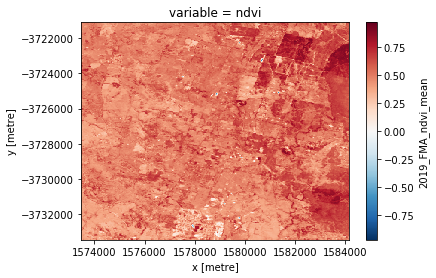

In [135]:
mean_3m.plot()

## Open VP dataset

In [158]:
vp_clim = xr.open_rasterio('./VP_test_NDVI_3mcomp_201902_201904.tif').squeeze()
# vp_clim=vp_clim.to_dataset()
print(vp_clim)

<xarray.DataArray (y: 411, x: 356)>
[146316 values with dtype=float64]
Coordinates:
    band     int64 1
  * y        (y) float64 -3.721e+06 -3.721e+06 ... -3.733e+06 -3.733e+06
  * x        (x) float64 1.573e+06 1.574e+06 1.574e+06 ... 1.584e+06 1.584e+06
Attributes:
    transform:      (30.0, 0.0, 1573470.0, 0.0, -30.0, -3721110.0)
    crs:            +init=epsg:3577
    res:            (30.0, 30.0)
    is_tiled:       1
    nodatavals:     (0.0,)
    scales:         (1.0,)
    offsets:        (0.0,)
    AREA_OR_POINT:  Area


In [ ]:
# clim.ndvi_clim_mean_DJF.plot(vmin=0, vmax=1.0, cmap='viridis')
# vp_clim.ndvi_clim_meanDJF.plot(vmin=0, vmax=1.0, cmap='viridis')

## Calculate deltas

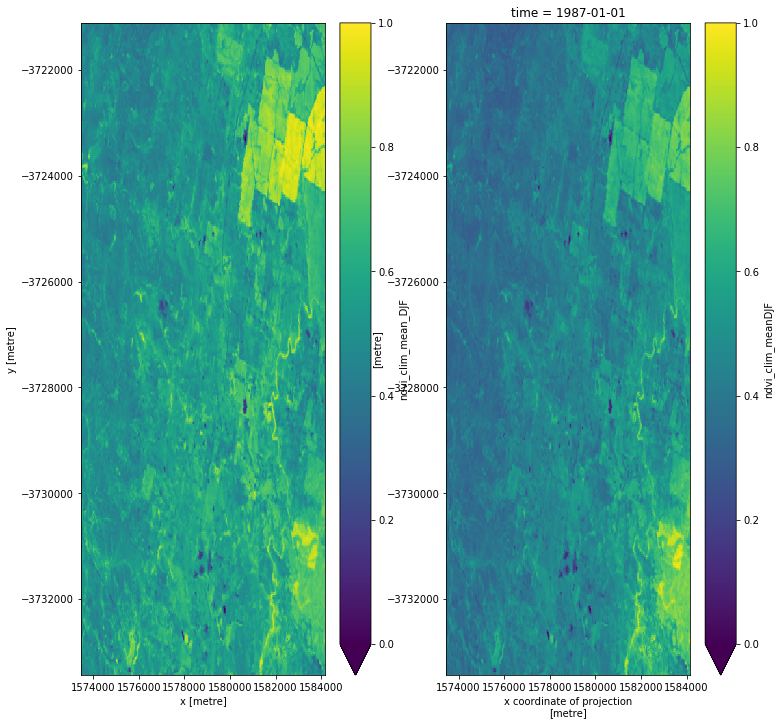

In [68]:
# standardize both datasets to see if relative values are similar  - they are not
DJF_std=clim.ndvi_clim_mean_DJF/clim.ndvi_clim_mean_DJF.max()
DJF_std_VP=vp_clim.ndvi_clim_meanDJF/vp_clim.ndvi_clim_meanDJF.max()
fig = plt.figure(figsize=(12,12))
ax = fig.subplots(nrows=1, ncols=2, sharex='all')
DJF_std.plot(ax=ax[0], cmap='viridis', vmin=0, vmax=1)
DJF_std_VP.plot(ax=ax[1], cmap='viridis', vmin=0, vmax=1)

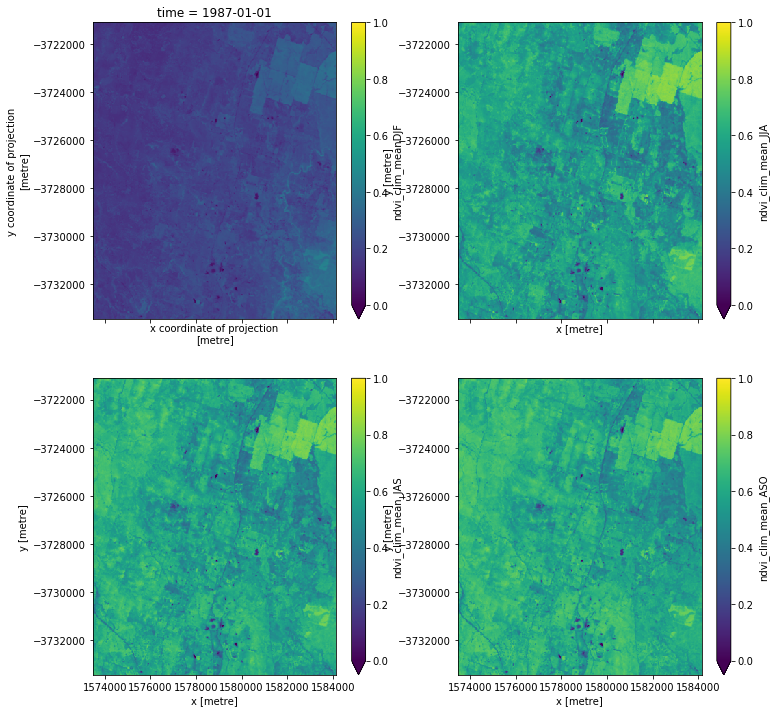

In [69]:
fig = plt.figure(figsize=(12,12))
ax = fig.subplots(nrows=2, ncols=2, sharex='all')
vp_clim.ndvi_clim_meanDJF.plot(ax=ax[0,0], cmap='viridis', vmin=0, vmax=1)
clim.ndvi_clim_mean_JJA.plot(ax=ax[0,1], cmap='viridis', vmin=0, vmax=1)
clim.ndvi_clim_mean_JAS.plot(ax=ax[1,0], cmap='viridis', vmin=0, vmax=1)
clim.ndvi_clim_mean_ASO.plot(ax=ax[1,1], cmap='viridis', vmin=0, vmax=1)

#scaling is clearly different.  vp looks too low (max values are all under .5)

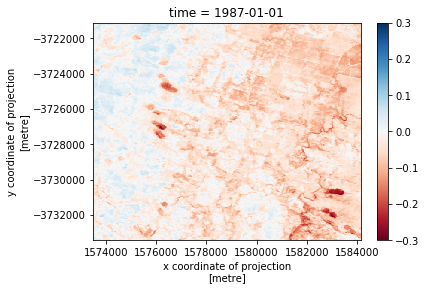

In [61]:
seasonaldiff_vp=vp_clim.ndvi_clim_meanJJA - vp_clim.ndvi_clim_meanDJF
seasonaldiff_vp.plot(vmin=-0.3,vmax=0.3,cmap='RdBu')

In [16]:
diff_DJF = clim.ndvi_clim_mean_DJF - vp_clim.ndvi_clim_meanDJF
diff_MAM = clim.ndvi_clim_mean_MAM - vp_clim.ndvi_clim_meanMAM
diff_JJA = clim.ndvi_clim_mean_JJA - vp_clim.ndvi_clim_meanJJA
diff_SON = clim.ndvi_clim_mean_SON - vp_clim.ndvi_clim_meanSON

### Plot differences, ideally every pixel will be zero

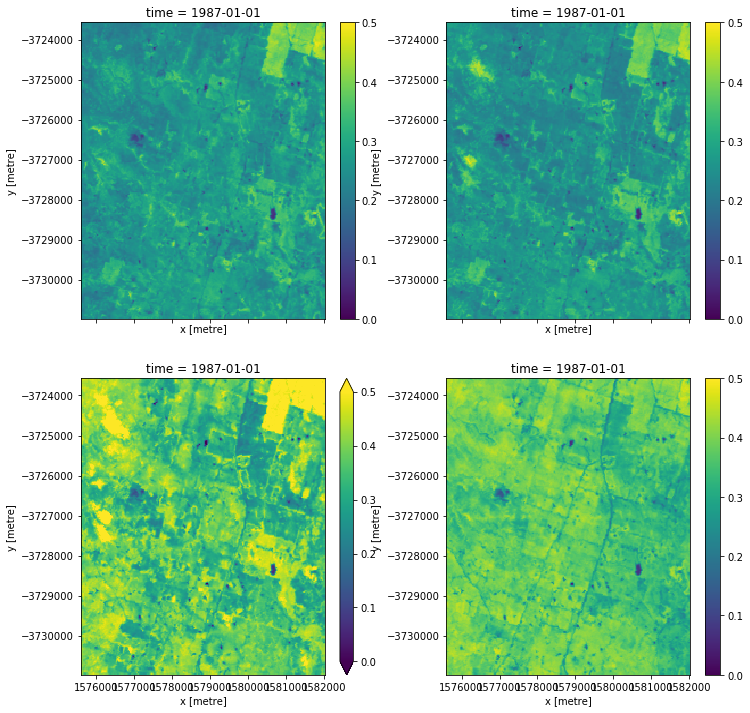

In [17]:
fig = plt.figure(figsize=(12,12))
ax = fig.subplots(nrows=2, ncols=2, sharex='all')
diff_DJF.plot(ax=ax[0,0], cmap='viridis', vmin=0, vmax=0.5)
diff_MAM.plot(ax=ax[0,1], cmap='viridis', vmin=0, vmax=0.5)
diff_JJA.plot(ax=ax[1,0], cmap='viridis', vmin=0, vmax=0.5)
diff_SON.plot(ax=ax[1,1], cmap='viridis', vmin=0, vmax=0.5)